In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import re

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [3]:
path1 = r'C:\Users\lmz\Desktop\2024C\附件1.xlsx'
path2 = r'C:\Users\lmz\Desktop\2024C\附件2.xlsx'

df_agriarea = pd.read_excel(path1, sheet_name='乡村的现有耕地')
df_agrikind = pd.read_excel(path1, sheet_name='乡村种植的农作物')
df_agrinum = pd.read_excel(path2, sheet_name='2023年的农作物种植情况') 
df_agrisell = pd.read_excel(path2, sheet_name='2023年统计的相关数据')
# sheet_names = pd.ExcelFile(path2).sheet_names
# print(sheet_names)

df_agriarea = df_agriarea.drop(columns=['说明 '])
df_agrikind = df_agrikind.drop(columns=['说明'])
df_agrikind = df_agrikind.drop(columns=['种植耕地'])
df_agrinum.ffill(inplace=True)
df_agrisell.columns, df_agrinum.columns

(Index(['序号', '作物编号', '作物名称', '地块类型', '种植季次', '亩产量/斤', '种植成本/(元/亩)',
        '销售单价/(元/斤)'],
       dtype='object'),
 Index(['种植地块', '作物编号', '作物名称', '作物类型', '种植面积/亩', '种植季次'], dtype='object'))

### 合并四个表


In [4]:
df_agriarea.columns = ['种植地块', '地块类型', '地块面积/亩']

df_merge1 = pd.merge(df_agrinum, df_agriarea, on='种植地块', how='left')

df_merge = pd.merge(df_merge1, df_agrisell, on=['作物编号', '地块类型'], how='left') 
df_merge.drop(columns=['种植季次_y','作物名称_y','序号'], inplace=True)

...
# 1-1


### 处理数据


In [5]:
price = df_merge['销售单价/(元/斤)']
beans = df_merge['作物类型']
is_beans = []
price_min = []
price_max = []
# 找到价格区间
for i in price:
    min = float(i.split('-')[0])
    max = float(i.split('-')[1])
    price_min.append(min)
    price_max.append(max)
# 找到豆类
for i in beans:
    if len(i) == 6:
        is_beans.append(1)
    else:
        is_beans.append(0)

df_merge['销售单价_min'] = price_min
df_merge['销售单价_max'] = price_max
df_merge['是否豆类'] = is_beans
df_merge['总产量'] = df_merge['亩产量/斤'] * df_merge['地块面积/亩']
df_merge['总成本'] = df_merge['地块面积/亩'] * df_merge['种植成本/(元/亩)']
df_merge['总收入'] = df_merge['总产量'] * (df_merge['销售单价_min'] + df_merge['销售单价_max']) / 2
df_merge['总利润'] = df_merge['总收入'] - df_merge['总成本']
df_merge1 = df_merge
df_merge['亩利润'] = df_merge['总利润'] / df_merge['地块面积/亩']
df_merge['总利润率'] = df_merge['总利润'] / df_merge['总成本']
df_merge.to_excel('merge.xlsx', index=False)


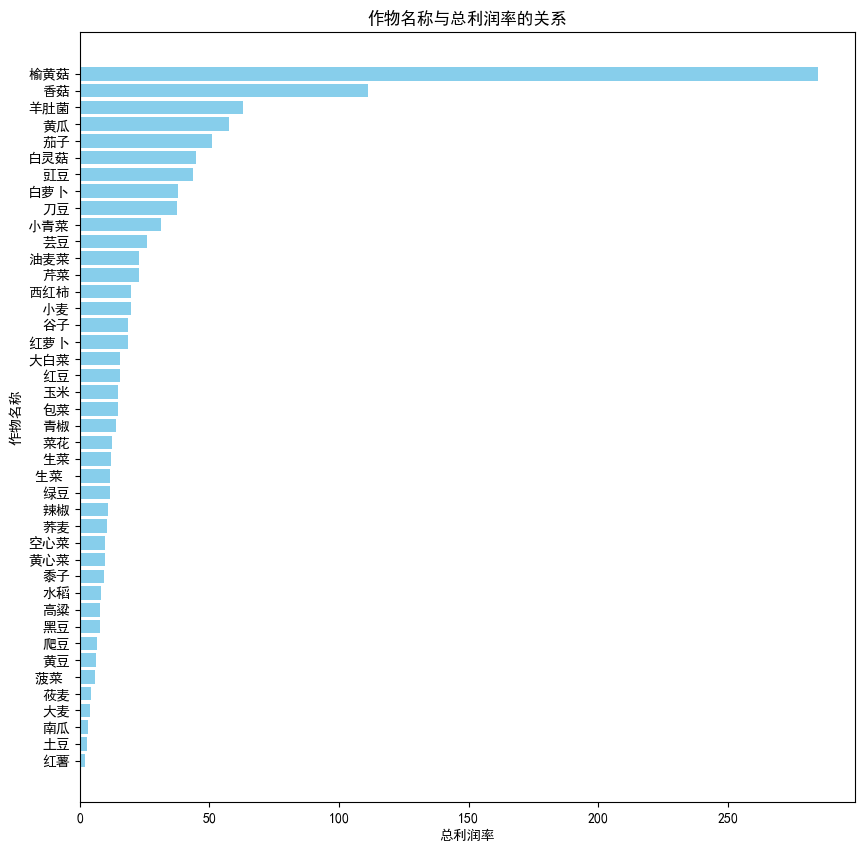

作物名称_x
红薯       2.250000
土豆       2.750000
南瓜       3.050000
大麦       4.000000
莜麦       4.500000
菠菜       5.900000
黄豆       6.262500
爬豆       6.617857
黑豆       7.906250
高粱       8.000000
水稻       8.294118
黍子       9.416667
黄心菜      9.603636
空心菜      9.800000
荞麦      10.428571
辣椒      11.083333
绿豆      11.600000
生菜      11.886364
生菜      12.125000
菜花      12.533333
青椒      14.220455
包菜      14.663636
玉米      14.700000
红豆      15.442857
大白菜     15.750000
红萝卜     18.500000
谷子      18.750000
小麦      19.644444
西红柿     19.982955
芹菜      23.000000
油麦菜     23.000000
芸豆      25.954545
小青菜     31.290909
刀豆      37.500000
白萝卜     38.000000
豇豆      43.636364
白灵菇     45.000000
茄子      50.933333
黄瓜      57.454545
羊肚菌     63.000000
香菇     111.000000
榆黄菇    284.500000
Name: 总利润率, dtype: float64

In [6]:
grouped = df_merge1.groupby('作物名称_x')['总利润率'].sum()
sorted_grouped = grouped.sort_values(ascending=True)
# 绘制条形图
plt.figure(figsize=(10, 10))
plt.barh(sorted_grouped.index, sorted_grouped.values, color='skyblue')
# 设置图表标题和标签
plt.title('作物名称与总利润率的关系')
plt.xlabel('总利润率')
plt.ylabel('作物名称')

# 显示图表
plt.show()

sorted_grouped

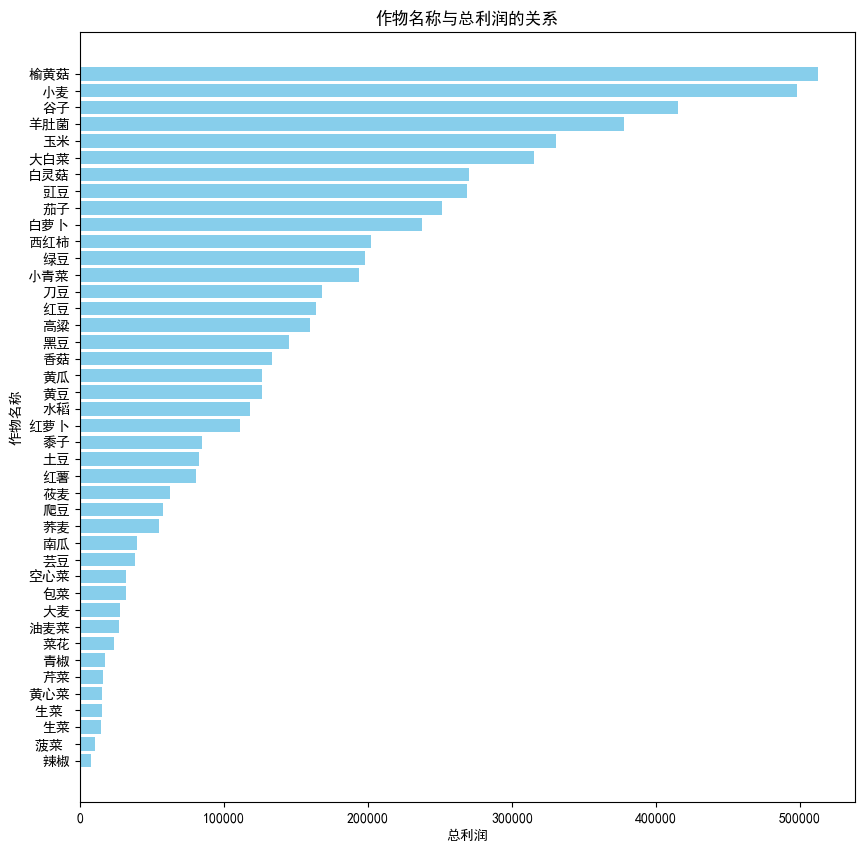

作物名称_x
辣椒       7980.00
菠菜      10620.00
生菜      14550.00
生菜      15690.00
黄心菜     15846.00
芹菜      16560.00
青椒      17946.00
菜花      23676.00
油麦菜     27600.00
大麦      28000.00
包菜      32328.00
空心菜     32340.00
芸豆      38592.00
南瓜      39650.00
荞麦      54750.00
爬豆      57906.25
莜麦      63000.00
红薯      81000.00
土豆      82500.00
黍子      84750.00
红萝卜    111000.00
水稻     118440.00
黄豆     126450.00
黄瓜     126630.00
香菇     133200.00
黑豆     145475.00
高粱     160000.00
红豆     163800.00
刀豆     168000.00
小青菜    194184.00
绿豆     197680.00
西红柿    202376.00
白萝卜    237500.00
茄子     251088.00
豇豆     268528.00
白灵菇    270000.00
大白菜    315000.00
玉米     330750.00
羊肚菌    378000.00
谷子     415350.00
小麦     498040.00
榆黄菇    512100.00
Name: 总利润, dtype: float64

In [7]:
grouped = df_merge1.groupby('作物名称_x')['总利润'].sum()
sorted_grouped = grouped.sort_values(ascending=True)
# 绘制条形图
plt.figure(figsize=(10, 10))
plt.barh(sorted_grouped.index, sorted_grouped.values, color='skyblue')
# 设置图表标题和标签
plt.title('作物名称与总利润的关系')
plt.xlabel('总利润')
plt.ylabel('作物名称')

# 显示图表
plt.show()

sorted_grouped

In [8]:
# 平旱地、梯田种植作物的种类
a_kind = df_agrikind.iloc[0:15, 1]
# 水浇地第一季种植作物的种类
b_kind = df_agrikind.iloc[15:34, 1]
# 水浇地第二季种植作物的种类
bb_kind = df_agrikind.iloc[34:37, 1] 
# 普通大棚第一季种植作物的种类
c_kind = df_agrikind.iloc[16:34, 1]
# 普通大棚第二季种植作物的种类
cc_kind = df_agrikind.iloc[37:41, 1]
# 智慧大棚第一季种植作物的种类
d_kind = df_agrikind.iloc[16:34, 1]
# 智慧大棚第二季种植作物的种类
dd_kind = df_agrikind.iloc[16:34, 1]


### 决策变量


In [19]:
# 平旱地、梯田种植情况
a = np.zeros(shape=(26, 15, 8))
# 水浇地第一季种植情况
b = np.zeros(shape=(8, 19, 8))
# 水浇地第二季种植情况
bb = np.zeros(shape=(8, 3, 8))
# 普通大棚第一季种植情况
c = np.zeros(shape=(16, 8, 8))
# 普通大棚第二季种植情况
cc = np.zeros(shape=(16, 4, 8))
# 智慧大棚第一季种植情况
d = np.zeros(shape=(4, 18, 8))
# 智慧大棚第二季种植情况
dd = np.zeros(shape=(4, 18, 8))
cnt = 0 
# 导入23年的数据
for i in range(26):
    for j in range(15): 
        if df_merge.iloc[i, 2] == a_kind.iloc[j]:
            # print(f'({i},{j})')
            a[i, j, 0] = 1

for i in range(8):
    for j in range(19):
        df_range = df_merge[(df_merge['地块类型'] == '水浇地') & ((df_merge['种植季次_x'] == '第一季') | (df_merge['种植季次_x']=='单季'))]
        # print(df_range)
        if df_range.iloc[i, 2] == b_kind.iloc[j]:
            # print(f'({i},{j})')
            b[i, j, 0] = 1

for i in range(8):
    for j in range(3):
        df_range = df_merge[(df_merge['地块类型'] == '水浇地') & ((df_merge['种植季次_x'] == '第二季') | (df_merge['种植季次_x']=='单季'))]
        if df_range.iloc[i, 2] == bb_kind.iloc[j]:
            # print(f'({i},{j})')
            bb[i, j, 0] = 1

for i in range(16):
    for j in range(8):
        df_range = df_merge[(df_merge['地块类型'] == '普通大棚 ') & (df_merge['种植季次_x'] == '第一季')]
        if df_range.iloc[i, 2] == c_kind.iloc[j]:
            # print(f'({i},{j})')
            c[i, j, 0] = 1

for i in range(16):
    for j in range(4):
        df_range = df_merge[(df_merge['地块类型'] == '普通大棚 ') & (df_merge['种植季次_x'] == '第二季')]
        if df_range.iloc[i, 2] == cc_kind.iloc[j]:
            # print(f'({i},{j})')
            cc[i, j, 0] = 1

for i in range(4):
    for j in range(18):
        df_range = df_merge[(df_merge['地块类型'] == '智慧大棚') & (df_merge['种植季次_x'] == '第一季')]
        if df_range.iloc[i, 2] == d_kind.iloc[j]:
            # print(f'({i},{j})')
            d[i, j, 0] = 1

for i in range(4):  
    for j in range(18):
        df_range = df_merge[(df_merge['地块类型'] == '智慧大棚') & (df_merge['种植季次_x'] == '第二季')]
        if df_range.iloc[i, j] == dd_kind.iloc[j]:
            # print(f'({i},{j})')
            dd[i, j, 0] = 1

   种植地块 作物编号 作物名称_x    作物类型  种植面积/亩 种植季次_x   地块类型  地块面积/亩    亩产量/斤  \
40   E1   18     刀豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   2400.0   
42   E2   24     青椒     蔬菜      0.6    第一季  普通大棚      0.6   3000.0   
44   E3   25     菜花     蔬菜      0.6    第一季  普通大棚      0.6   4000.0   
46   E4   26     包菜     蔬菜      0.6    第一季  普通大棚      0.6   4500.0   
48   E5   28    小青菜     蔬菜      0.6    第一季  普通大棚      0.6   4000.0   
50   E6   27    油麦菜     蔬菜      0.6    第一季  普通大棚      0.6   5000.0   
52   E7   19     芸豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   3600.0   
54   E8   19     芸豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   3600.0   
56   E9   18     刀豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   2400.0   
58  E10   17     豇豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   3600.0   
60  E11   17     豇豆  蔬菜（豆类）     0.6    第一季  普通大棚      0.6   3600.0   
62  E12   22     茄子     蔬菜      0.6    第一季  普通大棚      0.6   8000.0   
64  E13   21    西红柿     蔬菜      0.6    第一季  普通大棚      0.6   3000.0   
66  E14   29     黄瓜 

In [24]:
df_merge1 = df_merge1.drop_duplicates(subset='作物名称_x')
len(df_merge1)

42

### 目标函数

In [30]:
# 第i种作物的销售单价
P = np.zeros(shape=(42, 8))
for i in range(42):
    P[i, 0] = (df_merge1['销售单价_min'].iloc[i] + df_merge1['销售单价_max'].iloc[i]) / 2
# 第i种作物的地块面积
A = np.zeros(shape=(42, 8))
A[:, 0] = df_merge1['地块面积/亩']
# 第i种作物的亩产量
Y = np.zeros(shape=(42, 8))
Y[:, 0] = df_merge1['亩产量/斤']
# 第i种作物的预测销量
D = np.zeros(shape=(42, 8))
D[:, 0] = df_merge1['总产量']
# 第i种作物的总成本
C = np.zeros(shape=(42, 8))
C[:, 0] = df_merge1['总成本']

profit = np.zeros(shape=8)
for i in range(8):
    profit[i] = np.sum(D[:, i] * P[:, i] - C[:, i])

array([[80. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [55. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [72. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [68. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [55. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [46. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [40. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [25. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [50. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [25. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [35. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [20. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [15. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [13. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [18. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [15. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [15. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [10. ,  0. ,  0. ,  0. ,

### 约束条件